In [1]:
"""import our data"""

import numpy as np
from data import get_data_from_csv, get_labels_and_data_1st_column
import matplotlib.pyplot as plt
import math

# DATA FROM HERE: https://pjreddie.com/projects/mnist-in-csv/
file_test = '../data/MNIST/mnist_test.csv'
file_train = '../data/MNIST/mnist_train.csv'

data_test, m_test, n_test = get_data_from_csv(file_test)
Y_test, X_test = get_labels_and_data_1st_column(data_test)

data_train, m_train, n_train = get_data_from_csv(file_train)
Y_train, X_train = get_labels_and_data_1st_column(data_train)

assert n_test == n_train
n = n_test
m = m_test + m_train



In [2]:
"""making sure that our Y_test/Y_train are actually labels"""

assert Y_test.max() == 9
assert Y_train.max() == 9
assert X_test[0].max() != 9
assert X_train[0].max() != 9


In [3]:
# normalize pixel data to values between 0 and 1. Max = 255, min = 0, thus divide by 255
X_train = X_train / 255.
X_test = X_test / 255.

In [47]:


def loss(Y, Y_hat):
    return 1/2 * np.sum((Y - Y_hat)**2)

def softmax(s):
    return np.exp(s) / sum(np.exp(s))

In [18]:
class model():
    def __init__(self, X_dataset,Y_dataset, learning_rate = 0.1):
        self.X = X_dataset
        self.Y = Y_dataset
        self.W1 = np.random.rand(10, 784) -.5
        self.b1 = np.random.rand(10,1) -.5
        self.W2 = np.random.rand(10,10) -.5
        self.b2 = np.random.rand(10,1) -.5
        self.learning_rate = learning_rate
    
    def update(self,X_dataset, Y_dataset):
        self.X = X_dataset
        self.Y = Y_dataset

    def get_predictions(self,Y_hat):
        predictions = np.argmax(Y_hat,0)
        return predictions

    
    def accuracy(self, Y_hat, Y):
        
        predictions = self.get_predictions(Y_hat)
        return np.sum(predictions == Y) / Y.size
    
    def gradient_descent(self, iterations, learning_rate=0.5):

        m = self.X.shape[1]
        one_hot_Y = self.one_hot_encode(self.Y)
        for iteration in range(iterations):

            Z1, A1, Z2, Y_hat = self.forward_pass(X=self.X)

            DW1, Db1, DW2, Db2 = self.backwards_propagation(Y_hat,one_hot_Y, self.X,Z2, A1, Z1, m)
            self.update_params( DW1, Db1, DW2, Db2, self.learning_rate)

            accuracy = self.accuracy(Y_hat, self.Y)
            if iteration% 20 == 0:
                loss = self.cross_entropy_loss(one_hot_Y, Y_hat)
                print(f"Iteration={iteration} \n    {accuracy=}\n    {loss=}")

    
    def ReLU(self, n: float) -> float:
        """rectified linear unit activation function"""
        return np.maximum(n, 0)

    def ReLU_deriv(self, n: float) -> int:
        """"derivative of ReLU"""
        return n > 0

    def softmax(self, array: np.array) -> np.array:
        # collapses 1 dimension of array
        # np.exp(s) / sum(np.exp(s))
        return np.exp(array) / np.sum(np.exp(array), axis=0)

    def forward_pass(self, X):
        Z1 = np.dot(self.W1, X) + self.b1
        A1 = self.ReLU(Z1)
        Z2 = self.W2.dot(A1) + self.b2
        Y_hat = self.softmax(Z2) 
        return Z1, A1, Z2, Y_hat

    def one_hot_encode(self, Y: np.array, classes = 10):
        # first instantiate 0's which should be an array of len(Y) max(Y) 
        one_hot = np.zeros((Y.size,classes))
        one_hot[np.arange(Y.size), Y] = 1
        return one_hot.T

    def cross_entropy_loss(self, y_actual, y_predictions):
        num_samples=len(y_actual)
        class_targets =np.array(y_actual)
        y_actual = y_actual
        y_pred_clipped = np.clip(y_predictions, 1e-7, 1-1e-7)
        if len(y_actual.shape) ==1:
            targeted_predictions = y_pred_clipped[[range(num_samples), class_targets]]
        elif len(y_actual.shape) == 2:
            targeted_predictions = np.sum(y_pred_clipped.T * y_actual.T, axis=1)
        negative_log_likelihoods = -np.log(targeted_predictions)
        return np.mean(negative_log_likelihoods)
    

    def backwards_propagation(self, Y_hat, Y, X, Z2, A1, Z1, m):
        """


        
        n = number of possible encodings # in general, n can change through a network,
            but we're assuming that n is used for encodings and also layer size
        m = number of inputs, batch size

        x = number of datapoints per input
        X[x,m] = Input - m examples of x data points
        Y[n,m] = one-hot encoding of results: e.g. [[0,0,0,1,0,0], ... ] (with m encodings)
        W1[n,x] = weights applied to X
        b1[n,1] = biases applied to values going into Z1_n
        Z1[n,m] = pre-activation function values = W1[n,x] dot X[x,m] + b1[n,1]
        A1[n,m] = ReLU(Z1[n,m])
        W2[n,n] = weights applied to A1
        b2[n,1] = biases applied to values going into Z2_n
        Z2[n,m] = pre-softmax function values = W2[n,n] dot A1[n,m] + b2[n,1]
        Y_hat[n,m] = the estimate of Y = softmax(Z2[n,m])
        
        definition: Loss = L[m] = [L_0, L_1, ..., L_m] # possiblly L[1,m]
            = 1/2*np.sum((Y - Y_hat)**2)
            in other words for each row m:
                L_m = 1/2*sum[j from 0 to n] of (Y[j,m] - Y_hat[j,m])**2 
                = sum[j from 0 to n] of 1/2*Y[j,m]**2 - Y[j,m]*Y_hat[j,m] + 1/2*Y_hat[j,m]**2
    (1)     L = np.sum(1/2*Y**2 - Y*Y_hat + 1/2*Y_hat**2)
        We set this loss specifically so that the derivative works out nicely

        To minimize L, we want to see how L will change with respect to the variable
        that we can control, namely Y_hat.
        We can calculate how changing one of the values in Y_hat effects Y.
        DY_hat[j,m] = dL/dY_hat[j,m] = -Y[j,m] + Y_hat[j,m] 
        This generalizes because dL/dY_hat should be an array of shape Y.shape, with each
        value j corresponding to how much Y_hat[j] effects L given some specific input (m).
        NOTE: dL/dY_hat will show how to change Y_hat to *increase* L by 1 unit 
        (this will be true for all derivatives we calculate).
        dL/dY_hat = -Y + Y_hat (calculated derivative from (1))
        call this DY_hat for simplicity

        REMINDER: Y_hat[n,m] = softmax(Z2[n,m])
        NOTE: dSoftmax(X)/dX = softmax(X) dot (1-softmax(X)), but we will use 1 instead FOR SOME REASON???
        dY_hat/dZ2 = 1                    ####### not: softmax(Z2)*(1-softmax(Z2))
        thus, by chain rule:
        DZ2[n,m] = dL/dZ2 = dL/dY_hat * dY_hat/dZ2 = DY_hat * 1

        REMINDER: Z2[n,m] = W2[n,n] dot A1[n,m] + b2[n,1]
        dZ2/dW2[m,n] = A1[n,m].T[m,n] / m
        dZ2/db2[m,1] = np.sum(Z2[n,m])[m] / m
        Now, were ready to calculate DW2, Db2
        DW2[n,n] = dL/dW2 = dL/dZ2 * dZ2/dW2 = DZ2[n,m] dot A1.T[m,n] / m
        Db2[n,1] = dL/db2 = dL/dZ2 * dZ2/db2 = DZ2[n,m] dot np.sum(Z2[n,m])[m,1] / m 

        
        dZ2/dA1 = W2[n,n]
        DA1[n,n] = dL/dA1 = dL/dZ2 * dZ2/dA1 = DZ2[n,m] * W2[n,n]
        DZ1[x,x] = dL/dA1 * dA1/dZ1 = DA1[n,n] * ReLU_deriv(Z1)

        REMINDER: Z1[n,m] = W1[n,x] dot X[x,m] + b1[n,1]
        dZ1/dW1[m,n] = X[n,m].T[m,n] / m
        dZ1/db1[m,1] = np.sum(Z1[n,m])[m] / m
        Now, were ready to calculate DW1, Db1
        DW1[x,n] = dL/dW1 = dL/dZ1 * dZ1/dW1 = DZ1[x,x] dot X.T[x,n] / m
        Db1[n,1] = dL/db1 = dL/dZ2 * dZ1/db1 = DZ2[n,m] dot np.sum(Z2[n,m])[m,1] / m 
        
        """

        DZ2 =  -Y +Y_hat 
        DW2 = np.dot(DZ2,A1.T) / m
        
        Db2 = np.sum(DZ2) / m

        DZ1 = np.dot(self.W2.T, DZ2) * self.ReLU_deriv(Z1)

        DW1 = np.dot(DZ1, self.X.T) / m
        Db1 =  np.sum(DZ1) / m
        return DW1, Db1, DW2, Db2


    def update_params(self, dW1, db1, dW2, db2, learning_rate):
        self.W1 = self.W1 - learning_rate*dW1
        self.b1 = self.b1 - learning_rate*db1
        self.W2 = self.W2 - learning_rate*dW2
        self.b2 = self.b2 - learning_rate*db2


    def make_prediction(self,X):
        print(X.shape)
        _,_,_, Y_hat = self.forward_pass(X)
        predictions = self.get_predictions(Y_hat)
        return predictions

    def test_predict(self,sample_index):
        current_image = self.X[:, sample_index, None]
        sample = self.Y[sample_index]
        current_image = current_image.reshape((28,28))*255

        plt.gray()
        plt.imshow(current_image, interpolation="nearest")
        plt.show()
        sample = self.Y[sample_index]
        X_sample = self.X[sample_index]
        prediction = self.make_prediction(self.X[:,sample_index, None])
        print(f"{sample=} , prediction = {prediction}. Correct = {sample == prediction[0]}")

    def export_weights(self):
        return self.W1, self.b1, self.W2, self.b2
    
    def import_weights(self, W1, b1, W2, b2):
        self.W1 = W1
        self.b1 = b1
        self.W2 = W2
        self.b2 = b2


            


In [ ]:
mod = model(X_train, Y_train, learning_rate=0.05)


In [22]:

mod.gradient_descent(200)
saved_W1, saved_b1 , saved_W2 ,saved_b2  = mod.export_weights()



Iteration=0 
    accuracy=0.6940615676927949
    loss=0.9187216567685481
Iteration=20 
    accuracy=0.7069451157519292
    loss=0.8873495152471377
Iteration=40 
    accuracy=0.7176452940882349
    loss=0.8588208750456914
Iteration=60 
    accuracy=0.7276287938132302
    loss=0.832811768311251
Iteration=80 
    accuracy=0.7368622810380173
    loss=0.8090015843552026
Iteration=100 
    accuracy=0.7447457457624294
    loss=0.7871326331592372
Iteration=120 
    accuracy=0.7516125268754479
    loss=0.767022975745752
Iteration=140 
    accuracy=0.7587126452107535
    loss=0.7484723337249892
Iteration=160 
    accuracy=0.7660794346572443
    loss=0.7313080807233577
Iteration=180 
    accuracy=0.7713128552142535
    loss=0.7154003766542791


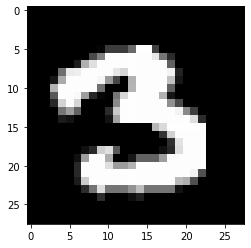

(784, 1)
sample=3 , prediction = [3]. Correct = True


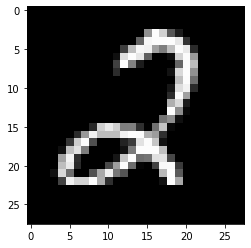

(784, 1)
sample=2 , prediction = [0]. Correct = False


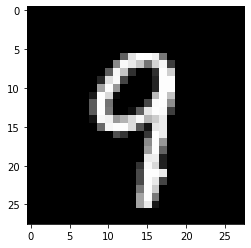

(784, 1)
sample=9 , prediction = [4]. Correct = False


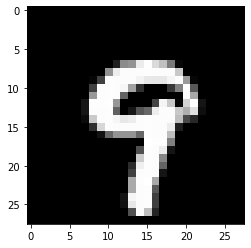

(784, 1)
sample=9 , prediction = [9]. Correct = True


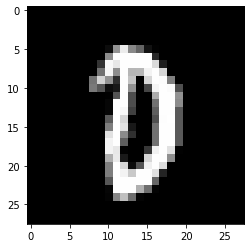

(784, 1)
sample=0 , prediction = [6]. Correct = False


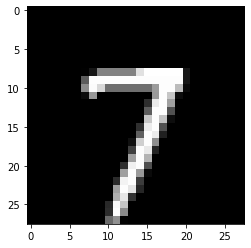

(784, 1)
sample=7 , prediction = [7]. Correct = True


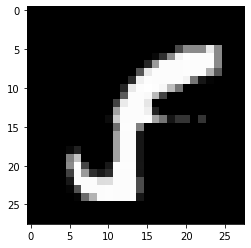

(784, 1)
sample=5 , prediction = [5]. Correct = True


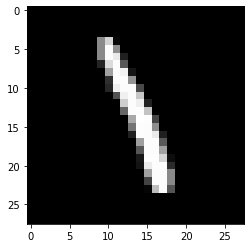

(784, 1)
sample=1 , prediction = [3]. Correct = False


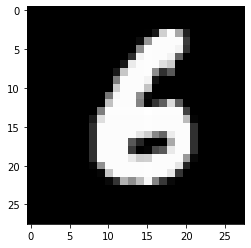

(784, 1)
sample=6 , prediction = [1]. Correct = False


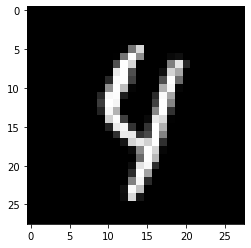

(784, 1)
sample=4 , prediction = [7]. Correct = False


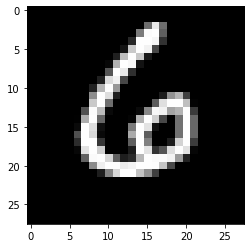

(784, 1)
sample=6 , prediction = [6]. Correct = True


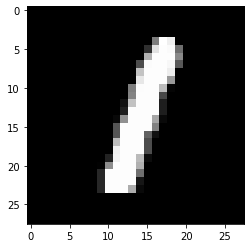

(784, 1)
sample=1 , prediction = [1]. Correct = True


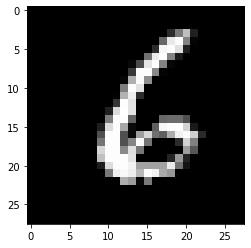

(784, 1)
sample=6 , prediction = [3]. Correct = False


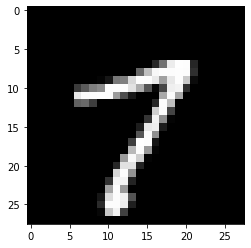

(784, 1)
sample=7 , prediction = [7]. Correct = True


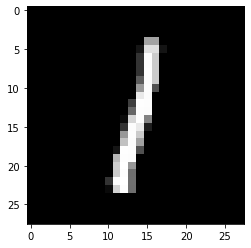

(784, 1)
sample=1 , prediction = [1]. Correct = True


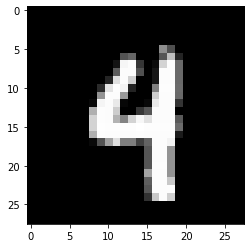

(784, 1)
sample=4 , prediction = [4]. Correct = True


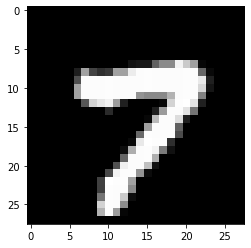

(784, 1)
sample=7 , prediction = [7]. Correct = True


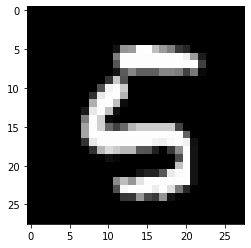

(784, 1)
sample=5 , prediction = [8]. Correct = False


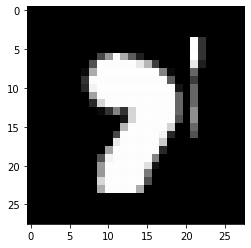

(784, 1)
sample=7 , prediction = [7]. Correct = True


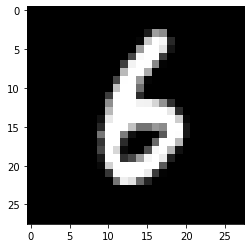

(784, 1)
sample=6 , prediction = [6]. Correct = True


In [ ]:
for i in range(5):
    mod.test_predict(i)
